# Ensemble Training and Random Forest

``` 
Suppose you pose complex questions to thousand of random people, then aggregate. 
Sometimes aggregate answer is better than expert's answer. This is called WISDOM OF THE CROWD 
Similarly, if we aggregate the group of predictors (Classifier/Regression). You can often get better prediction than individual predictors. This group of predictors are called ENSEMBLE 
We use ensemble method near the end of the project where we combine best predictors together.
``` 
1. Voting Classfier
    - Suppose we trained few classifiers and each of them achieving accuracy over 80%. Simple way to ensemble is to affregate prediction of each classifier and predict class getting max vote.
    - Sometimes ensemble classifier performs better than the best classifier in the ensemble. But how? 
        Say you have a biased coin with 51% probablity to get HEAD and 49% proablity to get TAIL. If tossed 1000 times we got effectively 510H and 490T. After 1000th event probablity to get Heads will be 75%. And if we keep increasing the event the probablity may go even up to 97% (10,000 toss). This is called LAW OF LARGE NUMBER. The probablity will try to move towards HEADS
    - Ensemble follows the same pricinple. However this is true only when classifiers are perfectly independent and making uncorrelated mistakes, which is clearly not the case as all classifiers will be trained on same training set 
    - Ensemble is likely to make same errors, so if there are many votes of wrong class, ensemble classifier accuracy will reduce.

In [1]:
import numpy as np 
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

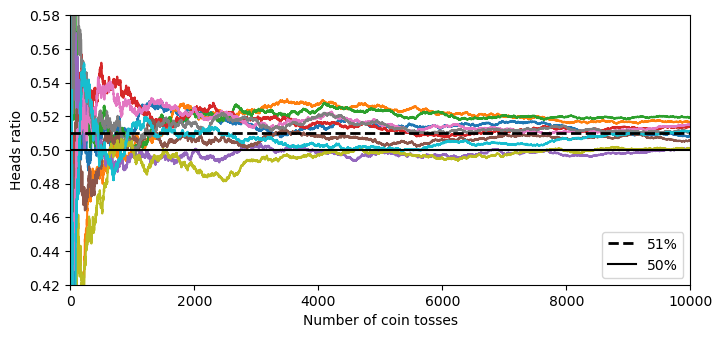

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

``` 
Using moon dataset using HARD VOTING

HARD VOTING -  Majority vote classifier is called Hard Voting 
```

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [5]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


``` 
Moon dataset using SOFT VOTING

SOFT VOTING - If classifiers are able to estimate probablity i.e. predict proba() method, then predict the class with highest class probablity and average over all individual classifier. This is called soft voting. 

Soft Voting ofen achives better performance as it gives more weights to very confident classifier vote.
```

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### 2. Bagging & Pasting
```
One way to train ensemble is to have training data fed to multiple predictors and aggregate the predictions made (using hard/soft voting)
Another way is to have same training algo for every model and train them on subset of randomly selected data. 

- When sampling is performed with replacement is called BAGGING (short for BOOTSTRAP AGGREGATION) 
- When sampling is performed without replacement is called PASTING. 

Bagging and Pasting allows training instances to be sampled several times across multiple predictors, but only bagging allows instances to be sampled several times for the same predictors
Once all predictors are trained, ensemble can make predictions for a new instance by simply aggregating predictions from all predictors 
Aggregation function is the statistical mode (most frequent) for classification or the average of predictions for regression

Generally net result of ensemble has similar bias but lower variance than single predictors trained on original training set 
Also, predictors in bagging and pasting can be trained in parallel via different CPU cores or different servedrs

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# create bagging classifier for moon dataset of 500 decision trees with each tree getting a sample of 100 with replacement (bootstrap=True). 
# To use Pasting method set bootstrap=False
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [11]:
# lets use singler DEcision tree classifier and compare the accuracy score 
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [12]:
# Lets plot the data points showing comparision between decision tree and bagging classifier 
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):

    # create data points 
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]

    # predict using classifier 
    y_pred = clf.predict(X_new).reshape(x1.shape)

    # create color map 
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

    # plot contour lines for predictions made
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    # plot the values for binary classified data 
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

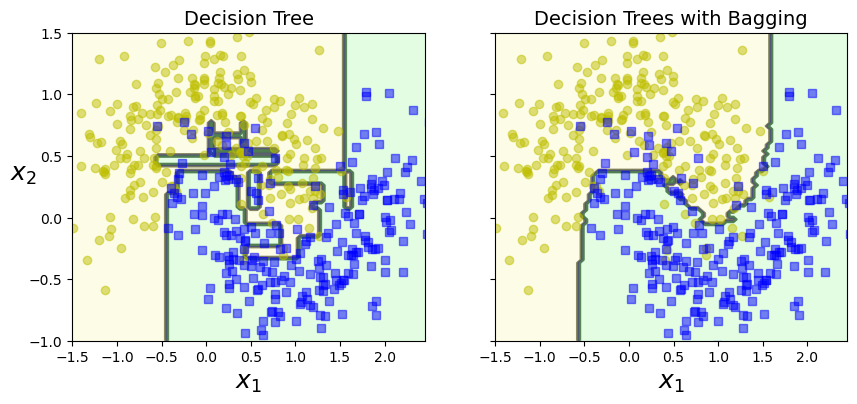

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)


plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

# 3. Out of Bag Evaluation 
``` 
- When bagging some of the instances may be sampled multiple times for any given predictor, while other may not be sampled at all. 
- By default bagging classifier with samples m training instances with replacement ( where m is size of training )
- This means about 63% (as m grows, ratio approaches 1-e^-1 which is 63%) of training set are sampled on average for each predictor
- Reamining 37% are not sampled at all - this is called OUT OF BAG instances 
- NOTE: They are not same 37% for all predictors 
- Since predictors never sees OOB instances, it can be used as validation set without need for separate validation set 
- you can use oob_score=True when creating bagging classifier to request auto evaluation of oob after training

In [14]:
# create a bagging classifier with 500 decision trees and set oob_score=True; n_jobs=-1 considers to use all availabnle CPU cores
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40, n_jobs=-1)
bag_clf.fit(X_train, y_train)

# get the oob_score 
bag_clf.oob_score_

0.8986666666666666

In [15]:
# oob decision function for each training instance is also available through oob_decision_function_ variable. 
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [16]:
from sklearn.metrics import accuracy_score

# predict the accuracy score 
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

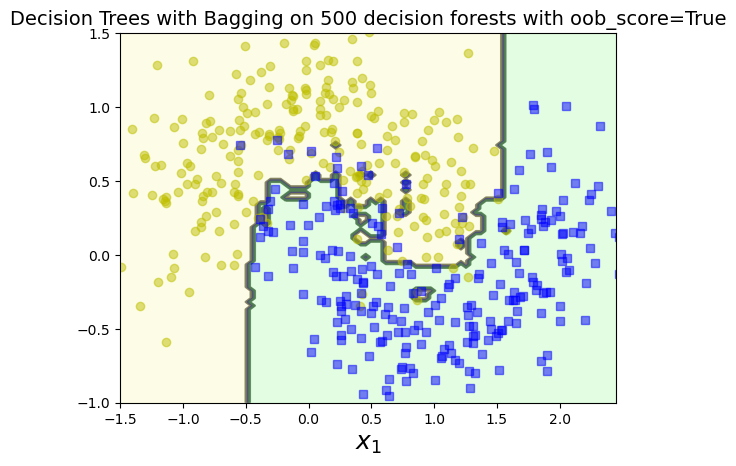

In [17]:
# plot thsi using datapoints generated
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging on 500 decision forests with oob_score=True", fontsize=14)
plt.ylabel("")
plt.show()

# 4. Random Forest
``` 
- Random forest is ensemble of decision trees trained via Bagging method (or sometimes using Pasting method)
- with max_sample - set this to the size of training set. 
- Instead of building bagging classifier and passing it to Decision Tree classifier; you can use Random Forest Classifier. 
- Similar to classifier, we also have RadomForestRegressor
- Random Forest has access to all hyperparameters of Decision Tree Classifier, plus hyperparameters of Bagging Classifier to control ensemble.
- Random forest also introduces bit of randomness when growing trees; instead of searching for best features when splitting node, it searches for best feature among random subset of feature. 
- Algo result in greater tree diversity which trades higher bias for a lower variance generally yielding better model 


In [18]:
from sklearn.ensemble import RandomForestClassifier

# create a random forest classifier with max leaf nodes limited to 16 with 500 decision trees
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

# predict the values of test set
y_pred_rf = rnd_clf.predict(X_test)

In [19]:
# create a bagging classifier with 500 deicision trees 
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [20]:
# train with training set and predict test set 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
# check if random forest predictions are same as bagging classifier 
np.sum(y_pred == y_pred_rf) / len(y_pred) 

np.float64(1.0)

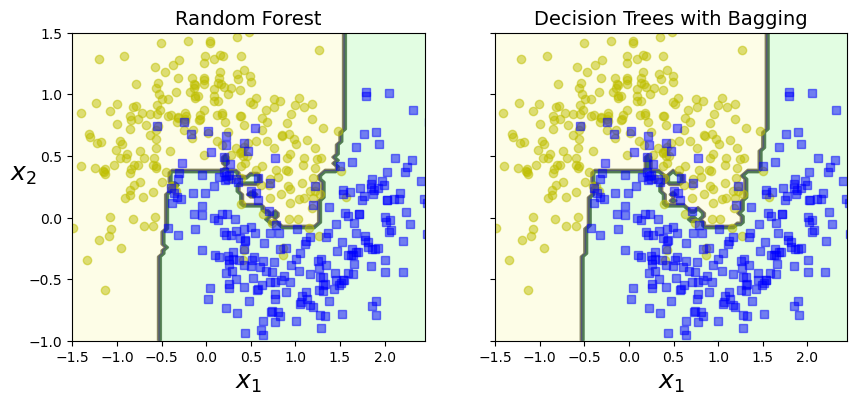

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(rnd_clf, X, y)
plt.title("Random Forest", fontsize=14)


plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

# 5. Feature Importance 

``` 
- One of the feature of random forest is to measure the relative importance of each feature. 
- Scikit measures feature importance by looking at how much tree nodes that use that feature reduce the impurity on an average. 
- It is weighted averagem where each node's weight is equal to the number of training samples that are associated with 
- Scikit computes this score automatically for each feature after training, then scales the result so that sum of all importance is equal to 1
```

In [23]:
# let' use iris dataset for feature importance 
from sklearn.datasets import load_iris

# load iris dataset 
iris = load_iris()

# create random forest classifier 
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

# train the classifier with iris dataset 
rnd_clf.fit(iris["data"], iris["target"])

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [24]:
# check for feature names and importance 
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print (name, score)

sepal length (cm) 0.11249225099876378
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.42335799635476823


``` 
this clearly shows the petal length and width importance is at 44% and 42% however sepal length and width is at 11% and 2%

``` 
Using MNIST dataset for feature importance 
``` 

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [27]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

[Text(1, 0.0, 'Not important'),
 Text(1, 0.009346914828859819, 'Very important')]

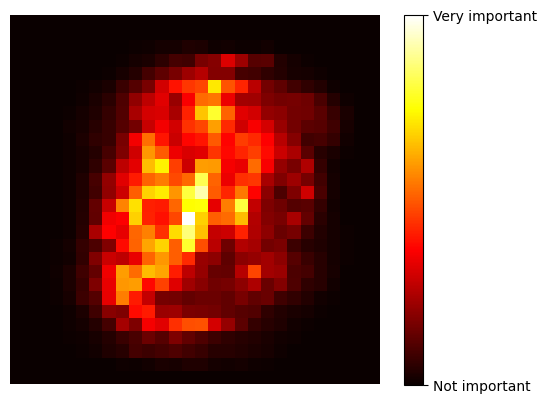

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# 6. Boosting 
``` 
- Originally called as Hypothesis Boosting 
- Refers to ensemble method that can combine several weak learners into a strong learner
- Idea is to train the predictors sequentially, each trying to correct its predecessor 
- Many boosting algo present: Famous are AdaBoost (aka Adaptive Boosting) and Grandient Boost

### AdaBoost
``` 
- One way to correct predecessor is by paying attention to training instances that predecessor underfits 
- For example when training adaboost classifier, algo first trains a Base Classifier and uses it to make predictions on training set. 
- Algo then increase weights of misclassified training instances then trains second classifier using updated weights and again makes prediction on training set and this process continues 
- Sequential learning technique is similar to grandient descen excpet tweaking predictor's parameter to minimize cost function, ADABOOST adds predictors to ensemble gradually making it better
- Once all predictors are trained, ADABOOST makes predictions very much similar to Bagging/Pasting.

* Drawback of sequential technique is it cannot be parallelized 

Scikit has a multiclass version of ADABOOST called SAMME (Stagewise Modelling using Multiclass Exponential loss function)

If predictors can estimate class probablity. Scikit can use a variant of SAMME called SAMME.R (here R stands for Real). SAMME.R relies on probablity hence performs better 

* SAMME.R is depreciated since V1.8! 


In [30]:
from sklearn.ensemble import AdaBoostClassifier

# create ADABOOST classifier and train on moon dataset with learning rate = 0.5 and 200 decision trees with depth=1
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

/Users/rohitabhishek/miniconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

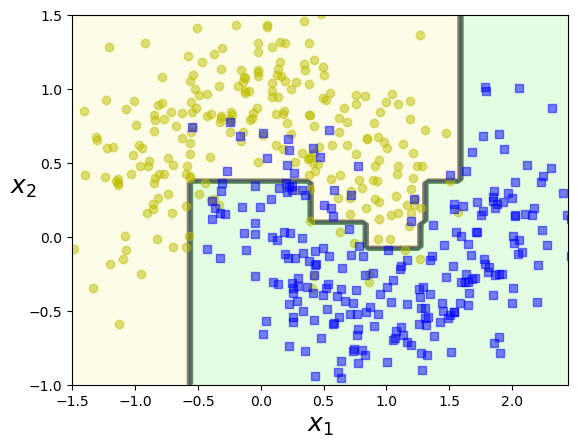

In [31]:
plot_decision_boundary(ada_clf, X, y)

In [32]:
ada_clf.score(X, y)

0.926

``` 
Creating decision boundary for moonset using SVC predictors
```

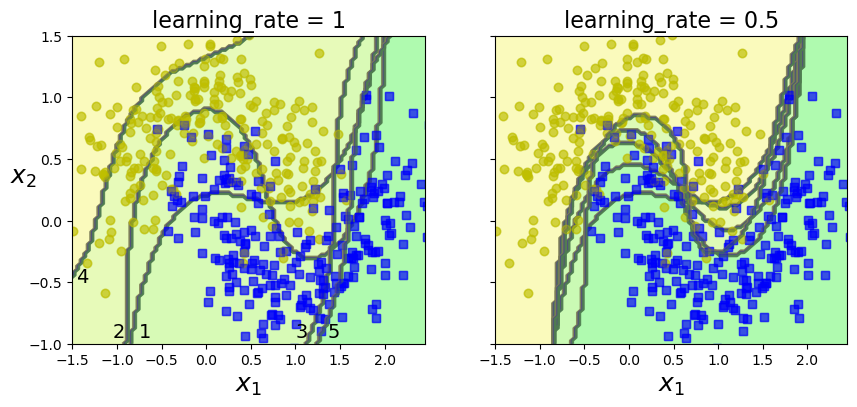

In [33]:
# get total training instances 
m = len(X_train)

# get figure and axes 
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# for subplot=0 set learning rate = 1 and for subplot=1 set learning rate=0.5
for subplot, learning_rate in ((0, 1), (1, 0.5)):

    # get sample weights 
    sample_weights = np.ones(m) / m

    plt.sca(axes[subplot])

    # iterate 5 time s
    for i in range(5):

        # create SVC Classifier with RBF kernel (similarity function) with low value of C making street wider; and gamma=0.6 for making bell shape narrower
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)

        # give weights to instances 
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        # get instances where model didn't preict the value and create weights for them
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()  #  equation 7-1

        # generate alpha value 
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        # plot the decision boundary 
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)

        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    
    # if subplot is for learning rate = 1; annotate learning curves 
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)

    else:
        plt.ylabel("")

plt.show()

### Gradient Boosting
```
- Same as ADABOOST, works sequentially by adding predictors to an ensemble each one of them correcting its predecessor 
- Instead of tweaking the instance weights every iteration like ADABOOST does, this method tries to fit the new predictor to residual error made by previous predictors 
- Using Decision Tree as Base Predictor (Gradient Boosting also does regression) is called Gradient Tree Boosting or Gradient Boosted Regression Tree (GBRT)

In [34]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [37]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [39]:
X_new = np.array([[0.8]])

In [40]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [41]:
y_pred

array([0.75026781])

``` 
Lets plot this the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions:

In [43]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Text(0, 0.5, '$y$')

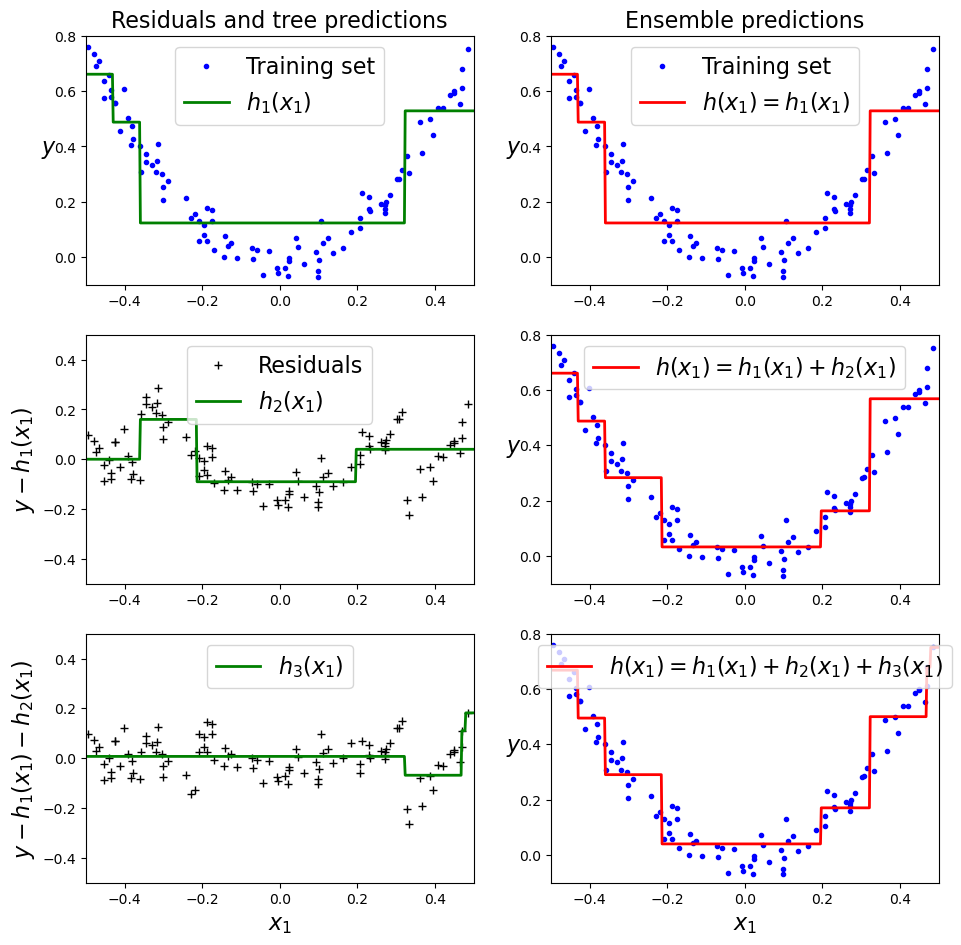

In [44]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

``` 
Above code (3 iterations of decision tree) can be replaced with below piece of code 
```

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

Text(0, 0.5, '$y$')

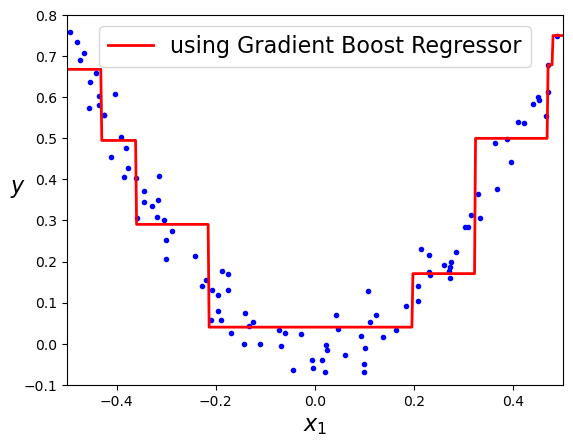

In [47]:
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="using Gradient Boost Regressor")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

```
if learning rate is low , you will need more trees in ensemble to fit the training set but the model will generalize better. This regularization technique is called SHIRNKAGE

In [48]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

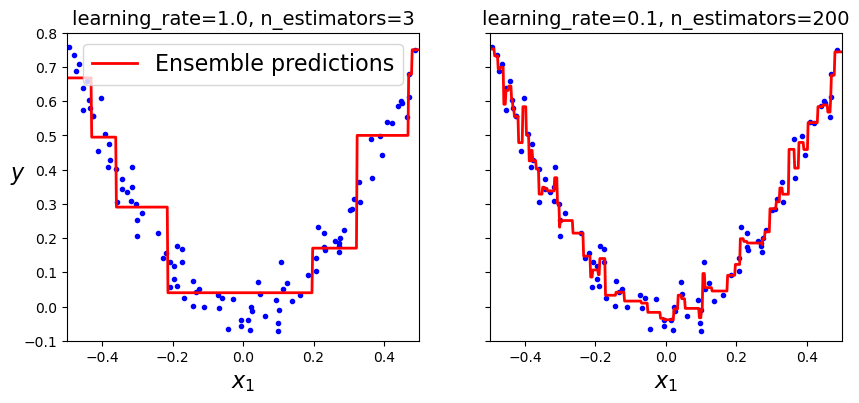

In [50]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

``` 
Early stopping for optimal solution 
```

In [51]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [53]:
gbrt.n_estimators_

61

In [54]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.0027128533252354643


In [55]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(56),
                          random_state=42)

In [56]:

min_error = np.min(errors)

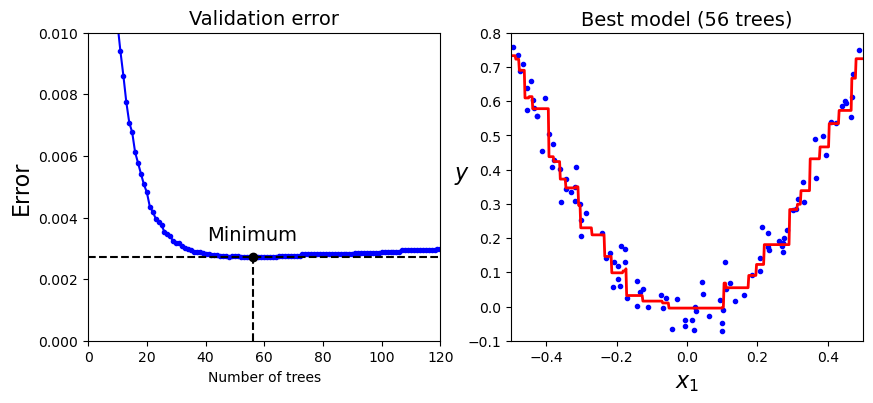

In [57]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

``` 
XGBoost

In [58]:
import xgboost

if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.004644479346317078


In [60]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)])
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown

    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
[8]	validation_0-rmse:0.05682
[9]	validation_0-rmse:0.05811
[10]	validation_0-rmse:0.05983
[11]	validation_0-rmse:0.06033
[12]	validation_0-rmse:0.06100
[13]	validation_0-rmse:0.06179
[14]	validation_0-rmse:0.06206
[15]	validation_0-rmse:0.06235
[16]	validation_0-rmse:0.06230
[17]	validation_0-rmse:0.06272
[18]	validation_0-rmse:0.06281
[19]	validation_0-rmse:0.06308
[20]	validation_0-rmse:0.06294
[21]	validation_0-rmse:0.06299
[22]	validation_0-rmse:0.06281
[23]	validation_0-rmse:0.06325
[24]	validation_0-rmse:0.06369
[25]	validation_0-rmse:0.06358
[26]	validation_0-rmse:0.06395
[27]	validation_0-rmse:0.06394
[28]	validation_0-rmse:0.06429
[29]	validation_0-rmse:0.06447
[30]	validation_0-rmse:0.06471
[31]	validation_0-rmse:0.06500
[32]	validation_0-

# Excercises 

``` 
Q1. Trained 5 different models on exact same training data and all achieve 95% precision. Is there anyway to combine these models together to get better result? If yes, how? If no, why?
Ans: Yes, we can use ensemble voting technique to get better result. The ensemble model will peform better if all these predictors are trained on different/random instances (Bagging and Pasting). If not trained on different instances, voting model will still perform better

Q2. Difference between hard and soft voting classifier? 
Ans: Hard voting considers majority of vote as technique to perform classification/regression task. Soft voting relies on probablity score (from predict_proba) method and average out the score across all the classfiers
Soft voting works on probablity and perform better than hard voting as it gives more weights to confident classifier vote. 

Q3. Can we speed up bagging ensemble by distributing it across multiple servers? What about pasting, boosting, random forest and stacking ensembles? 
Ans: bagging, pasting, random forest and stacking can be distributed across mutliple servers. 
boosting however is sequential in nature and cannot be distributed over multiple servers.

Q4. What is benefit of out of bag evaluation? 
Ans: When performing bagging instances can be randomly sampled multiple times while others may not be sampled at all. 
As per the math approximately 63% of the instances are sampled on average for each predictors. However 37% are not sampled at all - these are out of bag instances. These an be used for validation purposes without any need for separate validation set. 

Q5. What makes extra tree more random than regular random forest? how extra randomness helps? are extra trees faster than regular random forest? 
Ans: when growing trees in random forest at each node only a random subset of features is considered for splitting. To make this even more random we can use random threshold for each feature rather than searching for best possible threshold. Since most of time in random forest is spent on searching this best possbile feature, the extra tree helps in deteremining these random threshold values. With this approach we trade for more bias for lower variance. Also extra trees is faster

Q6. If adaboost ensemble underfits the training data, which hyperparameter should you tweak and how? 
Ans: Adaboost work on principle of correcting the wrong predictions by previous predictor in an ensemble. It will add more weights to incorrect predicted/classfied instances. You can try to increase number of estimators or reduce the regularization. If data is still underfitting it means, learning rate is quite low. Increase learning rate for model to fit properly.

Q7. If gradient boosting is overfitting should we increase or decrease the learning rate? 
Ans: reduce the learning rate. you can also try stop early technique for lower rmse 

#### Q8. Loead  MNIST dataset, split training, validation and test set. train various classifiers - Random forest, Extra tree and svm classifier. combine them into ensemble that outperforms on validation set, use soft and hard voting. Once done try on test set. compare result with individual classifiers. 

In [61]:
# load mnist dataset 
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [62]:
X, y = mnist['data'], mnist['target']

X.shape, y.shape

((70000, 784), (70000,))

In [63]:
# target is string - convert to integer 
y=y.astype(np.uint8)

In [64]:
# split training, validation and test set
X_train, X_val, X_test, y_train, y_val, y_test = X[:50000], X[50000:60000], X[60000:70000], y[:50000], y[50000:60000], y[60000:70000]
X_train.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

In [ ]:
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

# create SVC -> use probablity=False for hard voting 
svc_clf = SVC(random_state=42)

# create SVC -> use probablity=True for soft voting 
svc_clf_soft = SVC(random_state=42, probability=True)

# create random forest classifier 
rndn_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# create extra tree classifier 
etree_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)


# train each of these model and get the accuracy 
for clf in (svc_clf, svc_clf_soft, rndn_clf, etree_clf):
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_val_pred))

SVC 0.9802
SVC 0.9802
RandomForestClassifier 0.9718
ExtraTreesClassifier 0.9757


In [66]:
# create a hard voting ensemble 
hard_voting_clf = VotingClassifier(
    estimators=[
        ("svchard", svc_clf),
        ("rf", rndn_clf),
        ("etree", etree_clf)
    ],
    voting="hard"
)

hard_voting_clf.fit(X_train, y_train)
y_hard_pred = hard_voting_clf.predict(X_val)
print("Hard voting classifier", accuracy_score(y_val, y_hard_pred))

Hard voting classifier 0.9772


In [76]:
hard_voting_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

conf_mx_hard = confusion_matrix(y_val, y_hard_pred)
conf_mx_hard

array([[ 980,    0,    3,    1,    0,    0,    2,    0,    3,    2],
       [   0, 1054,    5,    1,    1,    1,    0,    0,    1,    1],
       [   3,    0,  970,    0,    2,    1,    2,    5,    5,    2],
       [   1,    0,    2, 1004,    0,   10,    0,    4,    6,    3],
       [   0,    4,    1,    0,  961,    0,    0,    1,    2,   14],
       [   4,    0,    2,   14,    2,  877,   10,    1,    3,    2],
       [   2,    0,    0,    0,    1,    1,  962,    0,    1,    0],
       [   1,    5,    7,    1,    3,    0,    0, 1067,    0,    6],
       [   2,    3,    3,    6,    0,    7,    2,    0,  980,    6],
       [   5,    3,    2,   10,    5,    5,    0,    9,    5,  917]])

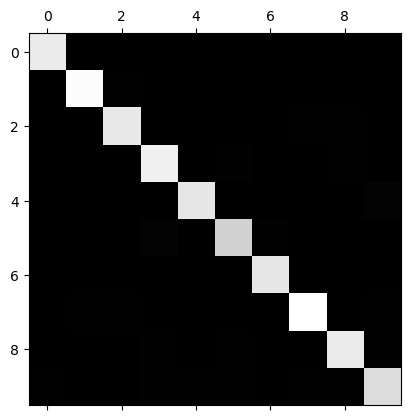

In [70]:
plt.matshow(conf_mx_hard, cmap=plt.cm.gray)

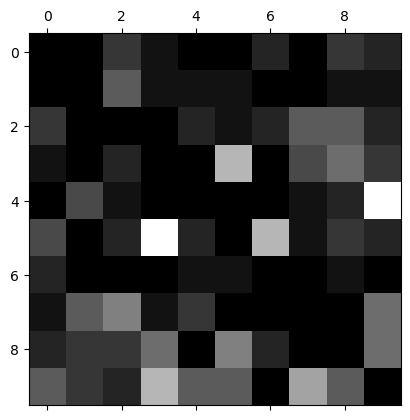

In [73]:
# visualize this in matplot - set diagonal elements to black 
np.fill_diagonal(conf_mx_hard, 0)
plt.matshow(conf_mx_hard, cmap=plt.cm.gray)
plt.show()

In [68]:
# create soft voting ensemble 
soft_voting_clf = VotingClassifier(
    estimators= [
        ("svcsoft", svc_clf_soft),
        ("rf", rndn_clf),
        ("etree", etree_clf)        
    ],
    voting="soft"
)

soft_voting_clf.fit(X_train, y_train)
y_soft_pred = soft_voting_clf.predict(X_val)
print("Soft voting classifier", accuracy_score(y_val, y_soft_pred))

Soft voting classifier 0.9814


In [75]:
soft_voting_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [71]:
conf_mx_soft = confusion_matrix(y_val, y_soft_pred)
conf_mx_soft

array([[ 980,    0,    4,    0,    0,    0,    2,    0,    3,    2],
       [   0, 1056,    4,    0,    1,    0,    0,    1,    1,    1],
       [   1,    0,  974,    0,    2,    1,    2,    5,    5,    0],
       [   0,    0,    3, 1007,    0,    7,    0,    3,    7,    3],
       [   0,    5,    0,    0,  966,    0,    0,    1,    1,   10],
       [   2,    0,    3,   15,    2,  880,    7,    1,    3,    2],
       [   1,    0,    0,    0,    1,    1,  963,    0,    1,    0],
       [   0,    5,    4,    0,    1,    0,    0, 1074,    0,    6],
       [   1,    2,    3,    6,    0,    3,    3,    0,  987,    4],
       [   2,    3,    1,    6,    6,    4,    0,    9,    3,  927]])

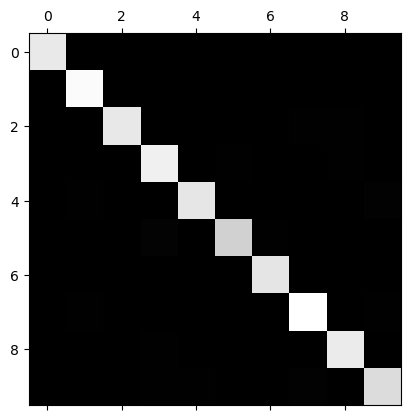

In [72]:
plt.matshow(conf_mx_soft, cmap=plt.cm.gray)

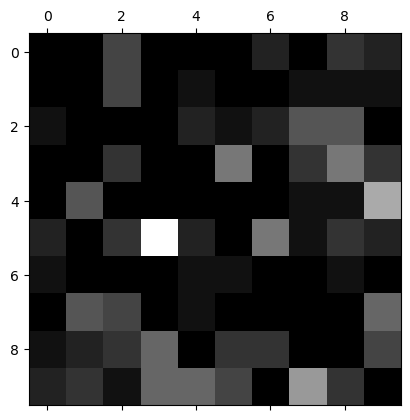

In [74]:
# visualize this in matplot - set diagonal elements to black 
np.fill_diagonal(conf_mx_soft, 0)
plt.matshow(conf_mx_soft, cmap=plt.cm.gray)
plt.show()

``` 
Soft Voting is .9814 and almost equal to SVC classifier. 

In [77]:
# store the models 
import joblib 
joblib.dump(hard_voting_clf, "/Users/rohitabhishek/Python_Workspace/hands-on-ml/SELF/OUTPUT/Chapter7/hard_voting_clf.pkl")
joblib.dump(soft_voting_clf, "/Users/rohitabhishek/Python_Workspace/hands-on-ml/SELF/OUTPUT/Chapter7/soft_voting_clf.pkl")

['/Users/rohitabhishek/Python_Workspace/hands-on-ml/SELF/OUTPUT/Chapter7/soft_voting_clf.pkl']

In [79]:
# test this on test data 
y_test_pred = hard_voting_clf.predict(X_test)
print("Hard voting classifier on test set", accuracy_score(y_test, y_test_pred))

Hard voting classifier on test set 0.9735


In [80]:
# test this on test data 
y_test_pred_soft = soft_voting_clf.predict(X_test)
print("Soft voting classifier on test set", accuracy_score(y_test, y_test_pred_soft))

Soft voting classifier on test set 0.9781


```
Q9. run individual classifiers from previous exercise to make predictions on the validation set, and create a new training set with resulting predictions. Each training instances is vector containing the set of predictions from all you classifiers for an image and target is the image class. Train a classifier on this new training set. 

In [82]:
# create estimators 
hard_estimators = [svc_clf, rnd_clf, etree_clf]
soft_estimators = [svc_clf_soft, rnd_clf, etree_clf]

In [83]:
X_val_predictions = np.empty((len(X_val), len(soft_estimators)), dtype=np.float32)

for index, estimator in enumerate(soft_estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [84]:
X_val_predictions

array([[3., 3., 3.],
       [8., 8., 8.],
       [6., 6., 6.],
       ...,
       [5., 5., 5.],
       [6., 6., 6.],
       [8., 8., 8.]], dtype=float32)

In [85]:
# pick random forest classifier as blender 
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [86]:
rnd_forest_blender.oob_score_

0.9981

In [87]:
X_test_predictions = np.empty((len(X_test), len(soft_estimators)), dtype=np.float32)

for index, estimator in enumerate(soft_estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [88]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [89]:
accuracy_score(y_test, y_pred)

0.997